We compare minimum average particle distance acorss trajecotry, last-step average particle distance across trajecotries, minimum average semantic distance across trajecotries, last-step average particle distance across trajectories, max_IoU agains the goal, automatically detected SR. We fix the trajecotry horizon as 20 regardless if it reaches success or not. Because, we also want to test the policies capability not to mess the success states. The evalaution arena should not have readjust pick assistance.

TODO:
1. Regenerate the oracle folding with fixed 20 horizon.
2. Generate the huma policy
3. in hydra train and eval, seperate the train trajectory setup from the eval trajecotry setup, because some algo needs the reajust-pick assistance.
    * use ray-capsulated arena for pyflex.

In [1]:
import os
import pandas as pd
import numpy as np
import ast


# -------------------------------
# HELPER: parse list-like strings
# -------------------------------

def parse_list(s):
    """Convert string like '[0.2, 0.1, 0.05]' into list of floats."""
    if isinstance(s, list):
        return s
    return ast.literal_eval(s)


# -------------------------------
# METRIC EXTRACTION LOGIC

def aggregate_performance(csv_path):
    df = pd.read_csv(csv_path)

    df["iou_flat"] = df["evaluation/max_IoU_to_flattened"].apply(parse_list)
    df["nc"] = df["evaluation/normalised_coverage"].apply(parse_list)
    df["ni"] = df["evaluation/normalised_improvement"].apply(parse_list)
    df["success_list"] = df["evaluation/success"].apply(parse_list)

    # ---------------------------
    # Extract per-row statistics
    # ---------------------------


    max_nc = [np.max(x) for x in df["nc"]]
    last_nc = [x[-1] for x in df["nc"]]
    max_ni = [np.max(x) for x in df["ni"]]
    last_ni = [x[-1] for x in df["ni"]]

    last_max_iou = [x[-1] for x in df["iou_flat"]]
    max_max_iou = [np.max(x) for x in df["iou_flat"]]

    # ---------------------------
    # Success + steps-to-finish
    # ---------------------------

    first_success_flags = []
    final_success_flags = []
    steps_to_first_success = []

    for success_list in df["success_list"]:
        if any(success_list):
            first_success_flags.append(1)
            steps_to_first_success.append(success_list.index(True))
        else:
            first_success_flags.append(0)
            steps_to_first_success.append(len(success_list) - 1)
        if success_list[-1]:
            final_success_flags.append(1)
        else:
            final_success_flags.append(0)

    # ---------------------------
    # Aggregated metrics (means)
    # ---------------------------


    max_iou_mean = np.mean(max_max_iou)
    #max_iou_flat_mean = np.mean(max_iou_flat)
    last_iou_mean = np.mean(last_max_iou)
    max_nc_mean = np.mean(max_nc)
    max_ni_mean = np.mean(max_ni)
    last_nc_mean = np.mean(max_nc)
    last_ni_mean = np.mean(max_ni)

    first_success_rate = np.mean(first_success_flags)
    final_success_rate = np.mean(final_success_flags)
    print('final_success_flags', final_success_flags)

    # ---------------------------
    # Standard deviations
    # ---------------------------
    #max_iou_flat_std = np.std(max_iou_flat)

    max_iou_std = np.std(max_max_iou)
    last_iou_std = np.std(last_max_iou)

    max_nc_std = np.std(max_nc)
    max_ni_std = np.std(max_ni)

    last_nc_std = np.mean(last_nc)
    last_ni_std = np.mean(last_ni)

    # ---------------------------
    # Episode counts
    # ---------------------------

    num_episodes = len(df)
    first_success_episodes = int(np.sum(first_success_flags))
    final_success_episodes = int(np.sum(final_success_flags))
    steps_to_finish_mean = np.mean(steps_to_first_success)
    steps_to_finish_std = np.std(steps_to_first_success)

    return {
        # Means

        "max_IoU_mean": max_iou_mean,
        #"max_IoU_to_flattened_mean": max_iou_flat_mean,
        "max_NC_mean": max_nc_mean, 
        "max_NI_std": max_ni_mean,
        "last_IoU_mean": last_iou_mean,
        "last_NC_mean": last_nc_mean,
        "last_NI_mean": last_ni_mean,
        "steps_to_first_success_mean": steps_to_finish_mean,

        # Standard deviations
        "max_IoU_std": max_iou_std,
        "last_IoU_std": last_iou_std,
        "last_NC_std": last_nc_std,
        "last_NI_std": last_ni_std,
        #"max_IoU_to_flattened_std": max_iou_flat_std,
        "steps_to_first_success_std": steps_to_finish_std,
        "max_NC_std": max_nc_std, 
        "max_NI_std": max_ni_std, 

        # Others
        "first_success_rate": first_success_rate,
        "final_success_rate": final_success_rate,
        "num_episodes": num_episodes,
        "first_success_episodes": first_success_episodes,
        "final_success_episodes": final_success_episodes
    }

In [2]:
# We evaluate the ability to flattening, ablilty to folding and ability to recover from failed folding states.
# first success in a trajectory --> ability to folding
# final step success in a trajectory --> ability to recognise success and recover from failures.

data_dir = "/mnt/ssd/garment_folding_data"
experiments = [
    {
        "name": "diffusion_dual_picker_single_primitive_multi_longsleeve_flattening_demo_20",
        "label": "Diffusion-Demo-20 (2, S)",
        "check": "eval_checkpoint_28000"
    },
    {
        "name": "random_multi_primitive_multi_longsleeve_flattening",
        "label": "Random (2, M)",
        "check": "eval_checkpoint_-1"
    },
    {
        "name": "lagarnet_single_picker_single_primitive_multi_longsleeve_flattening",
        "label": "LaGarNet (1, S)",
        "check": "eval_checkpoint_50000"
    }
]

rows = []

for exp in experiments:
    csv_path = os.path.join(
        data_dir,
        exp["name"],
        exp["check"],
        "performance.csv"
    )
    print('csv', csv_path)
    if not os.path.exists(csv_path):
        print(f"WARNING: Missing file: {csv_path}")
        continue

    metrics = aggregate_performance(csv_path)
    metrics["experiment"] = exp["label"]
    rows.append(metrics)

results_df = pd.DataFrame(rows)
cols = ["experiment"] + [c for c in results_df.columns if c != "experiment"]
results_df = results_df[cols]
display(results_df)

csv /mnt/ssd/garment_folding_data/diffusion_dual_picker_single_primitive_multi_longsleeve_flattening_demo_20/eval_checkpoint_28000/performance.csv
final_success_flags [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
csv /mnt/ssd/garment_folding_data/random_multi_primitive_multi_longsleeve_flattening/eval_checkpoint_-1/performance.csv
final_success_flags [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
csv /mnt/ssd/garment_folding_data/lagarnet_single_picker_single_primitive_multi_longsleeve_flattening/eval_checkpoint_50000/performance.csv
final_success_flags [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


,experiment,max_IoU_mean,max_NC_mean,max_NI_std,last_IoU_mean,last_NC_mean,last_NI_mean,steps_to_first_success_mean,max_IoU_std,last_IoU_std,last_NC_std,last_NI_std,steps_to_first_success_std,max_NC_std,first_success_rate,final_success_rate,num_episodes,first_success_episodes,final_success_episodes
0,"Diffusion-Demo-20 (2, S)",0.766864,0.871345,0.213728,0.707827,0.871345,0.725091,18.909091,0.112048,0.111557,0.827173,0.626191,2.108621,0.112783,0.272727,0.090909,11,3,1
1,"Random (2, M)",0.587750,0.675203,0.187849,0.457257,0.675203,0.291303,20.000000,0.058695,0.071435,0.503737,0.066993,0.000000,0.081545,0.000000,0.000000,30,0,0
2,"LaGarNet (1, S)",0.800657,0.975610,0.104126,0.696387,0.975610,0.951837,17.433333,0.036920,0.085117,0.912627,0.808703,4.224400,0.054753,0.400000,0.100000,30,12,3


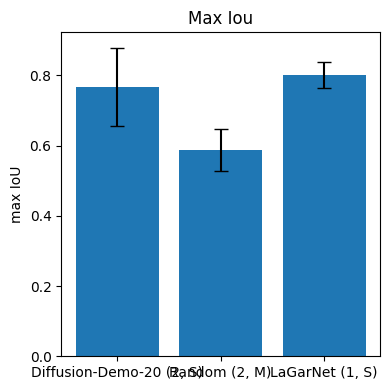

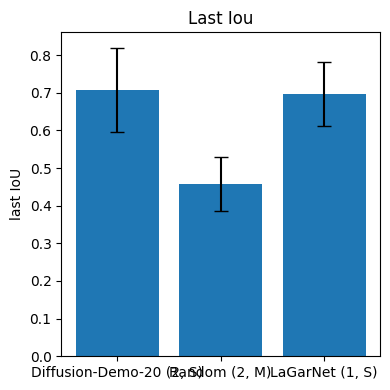

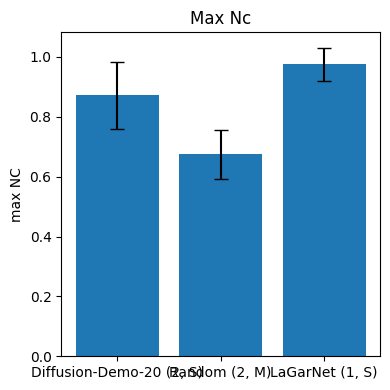

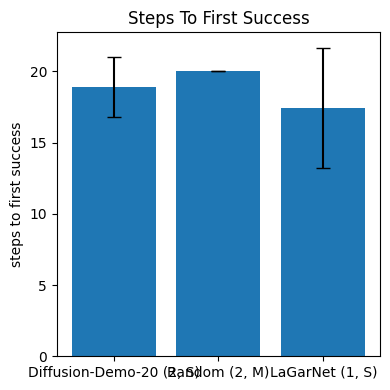

In [3]:
import matplotlib
# matplotlib.use("Agg")  # non-interactive, stable

import matplotlib.pyplot as plt

import numpy as np

# List of metrics you want to plot (base names without _mean / _std)
metrics = [
    "max_IoU",
    "last_IoU",
    "max_NC",
    "steps_to_first_success",
]

experiments = results_df["experiment"]

for metric in metrics:
    mean_col = f"{metric}_mean"
    std_col = f"{metric}_std"

    means = results_df[mean_col]
    stds = results_df[std_col]

    x = np.arange(len(experiments))

    plt.figure(figsize=(4, 4))
    plt.bar(x, means, yerr=stds, capsize=5)
    plt.xticks(x, experiments)
    plt.ylabel(metric.replace("_", " "))
    plt.title(f"{metric.replace('_', ' ').title()}")

    plt.tight_layout()
    plt.show()


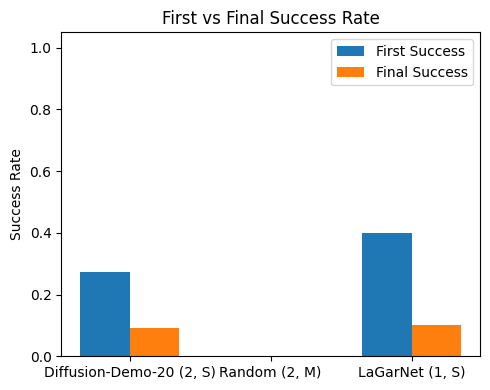

In [4]:
import matplotlib.pyplot as plt
import numpy as np

experiments = results_df["experiment"]
num_episodes = results_df["num_episodes"]

# Success rates
first_success = results_df["first_success_rate"]
final_success = results_df["final_success_rate"]

x = np.arange(len(experiments))
bar_width = 0.35

plt.figure(figsize=(5, 4))

plt.bar(
    x - bar_width / 2,
    first_success,
    bar_width,
    capsize=5,
    label="First Success",
)

plt.bar(
    x + bar_width / 2,
    final_success,
    bar_width,
    capsize=5,
    label="Final Success",
)

plt.xticks(x, experiments)
plt.ylabel("Success Rate")
plt.ylim(0, 1.05)
plt.legend()
plt.title("First vs Final Success Rate")

plt.tight_layout()
plt.show()


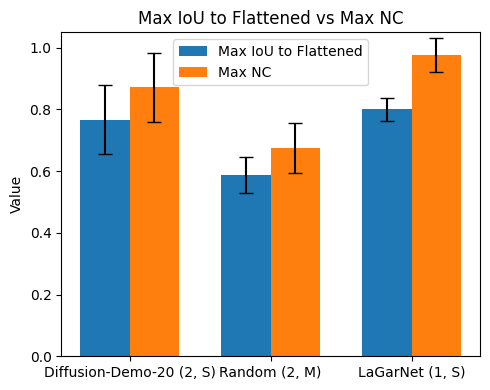

In [5]:
import matplotlib.pyplot as plt
import numpy as np

experiments = results_df["experiment"]
num_episodes = results_df["num_episodes"]

# Metrics
max_iou_flat = results_df["max_IoU_mean"]
max_nc = results_df["max_NC_mean"]

# Standard error
max_iou_flat_se = results_df["max_IoU_std"]
max_nc_se = results_df["max_NC_std"]

x = np.arange(len(experiments))
bar_width = 0.35

plt.figure(figsize=(5, 4))

plt.bar(
    x - bar_width/2,
    max_iou_flat,
    bar_width,
    yerr=max_iou_flat_se,
    capsize=5,
    label="Max IoU to Flattened",
)

plt.bar(
    x + bar_width/2,
    max_nc,
    bar_width,
    yerr=max_nc_se,
    capsize=5,
    label="Max NC",
)

plt.xticks(x, experiments)
plt.ylabel("Value")
plt.ylim(0, 1.05)
plt.title("Max IoU to Flattened vs Max NC")
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
# Define the metrics and whether they have a std column
metrics = [
    ("steps_to_first_success", True),  # has _mean and _std
    ("first_success_rate", False),     # no _mean, no _std
    ("final_success_rate", False),     # no _mean, no _std
    ("last_IoU", True),
    ("max_NC", True),
    ("max_IoU_to_flattened", True),
]

# Column labels for LaTeX
column_labels = [
    "S2F(\#)",
    "1st-SR (\%)",
    "Final-SR (\%)",
    "LM-IoU (Fold, \%)",
    "Max NC (\%)",
    "MM-IoU (Flat, \%)",
]

# Metrics to scale by 100
scale_100 = ["first_success_rate", "final_success_rate", 
             "last_IoU", "max_NC", "max_IoU_to_flattened"]

# Start LaTeX table
latex_table = "\\begin{tabular}{l" + "c"*len(metrics) + "}\n"
latex_table += "Experiment & " + " & ".join(column_labels) + " \\\\\n"
latex_table += "\\hline\n"

for idx, row in results_df.iterrows():
    row_values = []
    for metric, has_std in metrics:
        factor = 100 if metric in scale_100 else 1
        if has_std and f"{metric}_mean" in results_df.columns:
            mean_val = row[f"{metric}_mean"] * factor
            std_val = row[f"{metric}_std"] * factor
            row_values.append(f"${mean_val:.1f} \\pm {std_val:.1f}$")
        else:
            val = row[metric] * factor
            row_values.append(f"{val:.1f}")
    latex_table += f"{row['experiment']} & " + " & ".join(row_values) + " \\\\\n"

latex_table += "\\end{tabular}"

print(latex_table)


KeyError: 'max_IoU_to_flattened'